# Big Data Engineering Semester Project 


## Analysing gathered data

## Data sources

We obtained the folloiwng datasources:
- Housing data by webscraping Zillow (https://www.zillow.com/) an American real estate site. 


- Crime data we obtained from crime statistics available at the official government website. (https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2)


- GPS Location Data used to find latitude and longitude of a textual address (https://nominatim.openstreetmap.org/search/)

## Infrastructure

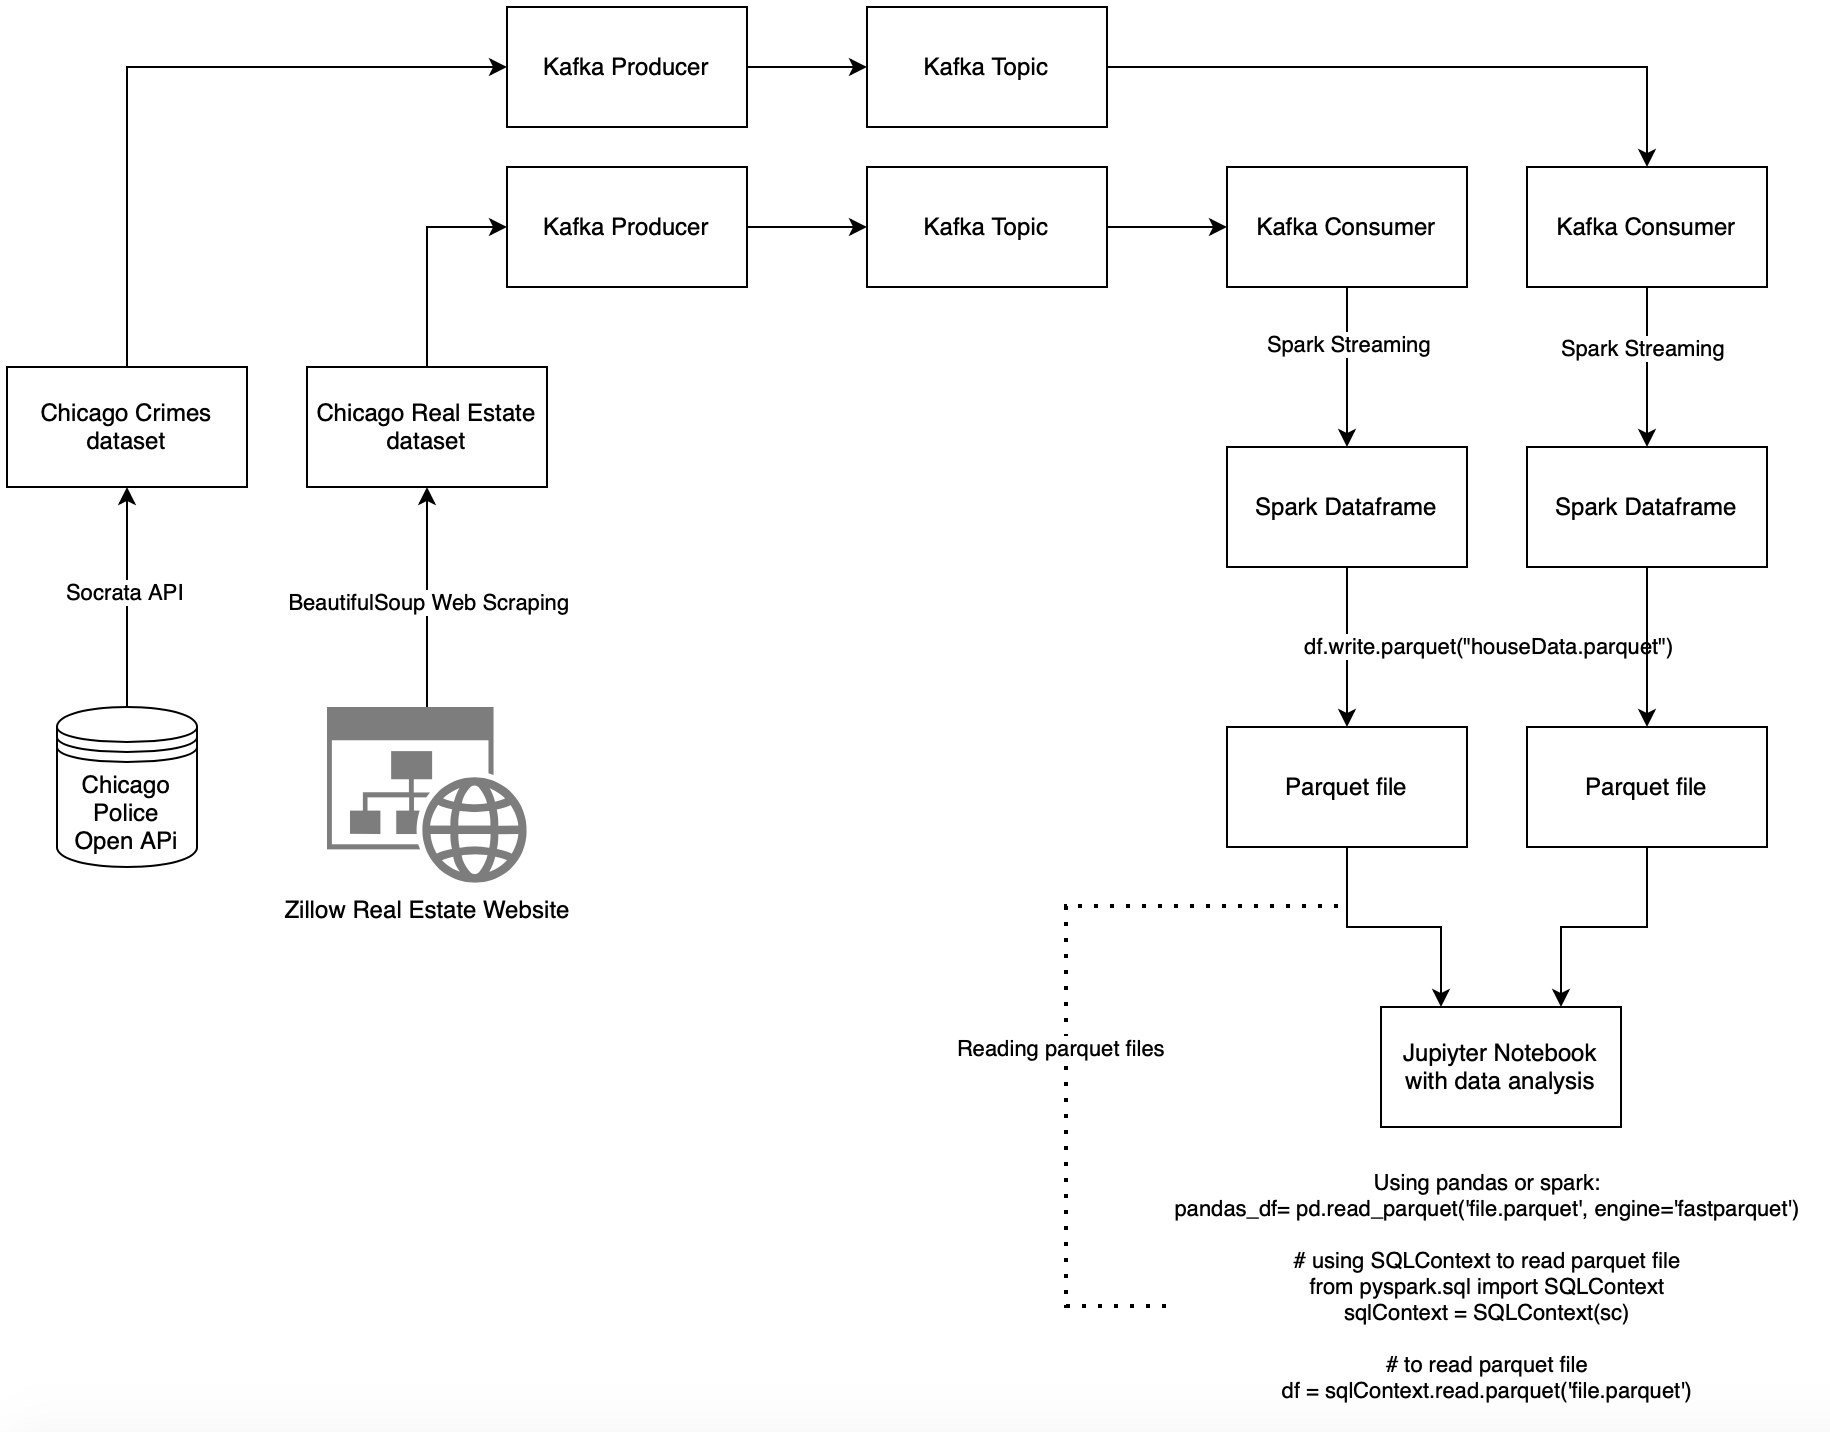

A simple overview of our infrastructure.

- First we read out the data by importing the crime dataset and scraping the real estate website in our producers.
- These producers write the data to our Kafka topics
- We then read them out in the consumers
- After this we convert the dataframes into parquet files.
- The parquet files are subsequently read out in this very notebook for analysis

## Data Analysis

### Preparation

In [6]:
import pandas as pd
import fastparquet
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable


props = pd.read_parquet('data.parquet', engine='fastparquet')
crimes = pd.read_parquet('crimeData.parquet', engine='fastparquet')

Importing all relevant libraries and importing our datasets from the Parquet files we created via our Kafka consumers

In [127]:
props

prices                                        address bed_bath_sqft  \
0    230000.0            11302 S Peoria St Chicago IL 60643      4|2|2000    
1    274900.0               3637 W 59th Pl Chicago IL 60629      2|1|1100    
2    219000.0   7641 N Eastlake Ter APT 1D Chicago IL 60626      2|2|1250    
3    108800.0       1132 W Lunt Ave APT 5B Chicago IL 60626      2|1|1054    
4   9400000.0                54 E Scott St Chicago IL 60610      2|1|1054    
..        ...                                            ...           ...   
85   549000.0            5605 N Ottawa Ave Chicago IL 60631      4|4|2904    
86   265000.0   625 W Jackson Blvd APT 310 Chicago IL 60661      2|1|1100    
87   345000.0      5306 N Glenwood Ave #2A Chicago IL 60640       3|1|735    
88   435000.0      300 W Grand Ave APT 602 Chicago IL 60654       1|1|900    
89   534900.0        1522 N Leamington Ave Chicago IL 60651      2|2|1100    

                                          links  bed  bath  sqft  
0            11302 S Peoria St Chicago IL 60643  NaN   NaN   NaN  
1               3637 W 59th Pl Chicago IL 60629  NaN   NaN   NaN  
2   7641 N Eastlake Ter APT 1D Chicago IL 60626  NaN   NaN   NaN  
3       1132 W Lunt Ave APT 5B Chicago IL 60626  NaN   NaN   NaN  
4                54 E Scott St Chicago IL 60610  NaN   NaN   NaN  
..                                          ...  ...   ...   ...  
85           5605 N Ottawa Ave Chicago IL 60631  NaN   NaN   NaN  
86  625 W Jackson Blvd APT 310 Chicago IL 60661  NaN   NaN   NaN  
87     5306 N Glenwood Ave #2A Chicago IL 60640  NaN   NaN   NaN  
88     300 W Grand Ave APT 602 Chicago IL 60654  NaN   NaN   NaN  
89       1522 N Leamington Ave Chicago IL 60651  NaN   NaN   NaN  

[90 rows x 7 columns]

Sadly our bed bath and square footage did not survive the import, but we can clean it up by splitting the bed_bath_sqft column again and overwriting our invalid values.

In [25]:
try:
    x = props [['bed','bath','sq_ft']] = props.bed_bath_sqft.str.split("|",expand=True)
except ValueError:
    pass
props = props.drop('sqft', 1)

/var/folders/vr/48qd0dvd3zx5h01r32l1_5k40000gn/T/ipykernel_64946/3741522338.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  props = props.drop('sqft', 1)


In [30]:
props = props.dropna()
props

prices                                        address bed_bath_sqft  \
0    230000.0            11302 S Peoria St Chicago IL 60643      4|2|2000    
1    274900.0               3637 W 59th Pl Chicago IL 60629      2|1|1100    
2    219000.0   7641 N Eastlake Ter APT 1D Chicago IL 60626      2|2|1250    
3    108800.0       1132 W Lunt Ave APT 5B Chicago IL 60626      2|1|1054    
4   9400000.0                54 E Scott St Chicago IL 60610      2|1|1054    
..        ...                                            ...           ...   
85   549000.0            5605 N Ottawa Ave Chicago IL 60631      4|4|2904    
86   265000.0   625 W Jackson Blvd APT 310 Chicago IL 60661      2|1|1100    
87   345000.0      5306 N Glenwood Ave #2A Chicago IL 60640       3|1|735    
88   435000.0      300 W Grand Ave APT 602 Chicago IL 60654       1|1|900    
89   534900.0        1522 N Leamington Ave Chicago IL 60651      2|2|1100    

                                          links bed bath   sq_ft    pricesqft  
0            11302 S Peoria St Chicago IL 60643   4    2  2000.0   115.000000  
1               3637 W 59th Pl Chicago IL 60629   2    1  1100.0   249.909091  
2   7641 N Eastlake Ter APT 1D Chicago IL 60626   2    2  1250.0   175.200000  
3       1132 W Lunt Ave APT 5B Chicago IL 60626   2    1  1054.0   103.225806  
4                54 E Scott St Chicago IL 60610   2    1  1054.0  8918.406072  
..                                          ...  ..  ...     ...          ...  
85           5605 N Ottawa Ave Chicago IL 60631   4    4  2904.0   189.049587  
86  625 W Jackson Blvd APT 310 Chicago IL 60661   2    1  1100.0   240.909091  
87     5306 N Glenwood Ave #2A Chicago IL 60640   3    1   735.0   469.387755  
88     300 W Grand Ave APT 602 Chicago IL 60654   1    1   900.0   483.333333  
89       1522 N Leamington Ave Chicago IL 60651   2    2  1100.0   486.272727  

[90 rows x 8 columns]

For further analysis we add a price per square feet column to the dataset.

In [27]:
props['sq_ft'] = props['sq_ft'].astype('float')
props['pricesqft'] = props.apply(lambda row: row.prices / row.sq_ft, axis = 1)
props

prices                                        address bed_bath_sqft  \
0    230000.0            11302 S Peoria St Chicago IL 60643      4|2|2000    
1    274900.0               3637 W 59th Pl Chicago IL 60629      2|1|1100    
2    219000.0   7641 N Eastlake Ter APT 1D Chicago IL 60626      2|2|1250    
3    108800.0       1132 W Lunt Ave APT 5B Chicago IL 60626      2|1|1054    
4   9400000.0                54 E Scott St Chicago IL 60610      2|1|1054    
..        ...                                            ...           ...   
85   549000.0            5605 N Ottawa Ave Chicago IL 60631      4|4|2904    
86   265000.0   625 W Jackson Blvd APT 310 Chicago IL 60661      2|1|1100    
87   345000.0      5306 N Glenwood Ave #2A Chicago IL 60640       3|1|735    
88   435000.0      300 W Grand Ave APT 602 Chicago IL 60654       1|1|900    
89   534900.0        1522 N Leamington Ave Chicago IL 60651      2|2|1100    

                                          links bed bath   sq_ft    pricesqft  
0            11302 S Peoria St Chicago IL 60643   4    2  2000.0   115.000000  
1               3637 W 59th Pl Chicago IL 60629   2    1  1100.0   249.909091  
2   7641 N Eastlake Ter APT 1D Chicago IL 60626   2    2  1250.0   175.200000  
3       1132 W Lunt Ave APT 5B Chicago IL 60626   2    1  1054.0   103.225806  
4                54 E Scott St Chicago IL 60610   2    1  1054.0  8918.406072  
..                                          ...  ..  ...     ...          ...  
85           5605 N Ottawa Ave Chicago IL 60631   4    4  2904.0   189.049587  
86  625 W Jackson Blvd APT 310 Chicago IL 60661   2    1  1100.0   240.909091  
87     5306 N Glenwood Ave #2A Chicago IL 60640   3    1   735.0   469.387755  
88     300 W Grand Ave APT 602 Chicago IL 60654   1    1   900.0   483.333333  
89       1522 N Leamington Ave Chicago IL 60651   2    2  1100.0   486.272727  

[90 rows x 8 columns]

In [131]:
crimes = crimes.dropna()
crimes

id case_number                date                  block  iucr  \
0      12736693    JF287903 2022-06-20 21:56:00  007XX W GARFIELD BLVD  0486   
1      12736637    JF287926 2022-06-20 21:56:00     015XX S KARLOV AVE  143A   
2      12736641    JF287904 2022-06-20 21:54:00      005XX N OGDEN AVE  051A   
3      12736591    JF287899 2022-06-20 21:54:00     034XX S ARCHER AVE  1345   
4      12736636    JF287914 2022-06-20 21:52:00       006XX W 103RD ST  1320   
...         ...         ...                 ...                    ...   ...   
99995  12579526    JE491744 2021-12-29 09:11:00       047XX W ADAMS ST  1477   
99996  12579529    JE491750 2021-12-29 09:09:00       123XX S YALE AVE  1477   
99997  12579610    JE491722 2021-12-29 09:08:00   005XX N MICHIGAN AVE  0460   
99998  12579538    JE491797 2021-12-29 09:00:00      056XX W NORTH AVE  1320   
99999  12580798    JE492923 2021-12-29 09:00:00        020XX E 80TH ST  1310   

            primary_type                    description location_description  \
0                BATTERY        DOMESTIC BATTERY SIMPLE            APARTMENT   
1      WEAPONS VIOLATION  UNLAWFUL POSSESSION - HANDGUN               STREET   
2                ASSAULT           AGGRAVATED - HANDGUN               STREET   
3        CRIMINAL DAMAGE    TO CITY OF CHICAGO PROPERTY               STREET   
4        CRIMINAL DAMAGE                     TO VEHICLE               STREET   
...                  ...                            ...                  ...   
99995  WEAPONS VIOLATION     RECKLESS FIREARM DISCHARGE                ALLEY   
99996  WEAPONS VIOLATION     RECKLESS FIREARM DISCHARGE                ALLEY   
99997            BATTERY                         SIMPLE     DEPARTMENT STORE   
99998    CRIMINAL DAMAGE                     TO VEHICLE            RESIDENCE   
99999    CRIMINAL DAMAGE                    TO PROPERTY            RESIDENCE   

      arrest domestic  ... ward community_area x_coordinate y_coordinate  \
0      false     true  ...   20             68      1172439      1868272   
1       true    false  ...   24             29      1149303      1892129   
2       true    false  ...   27             24      1167891      1903682   
3      false    false  ...   12             59      1163091      1881589   
4      false    false  ...    9             73      1173886      1836576   
...      ...      ...  ...  ...            ...          ...          ...   
99995   true    false  ...   28             25      1144798      1898706   
99996  false    false  ...   34             53      1176840      1823134   
99997   true    false  ...   42              8      1177342      1903838   
99998  false    false  ...   29             25      1138253      1910065   
99999  false    false  ...    8             46      1191352      1852335   

                    updated_on      latitude      longitude location.latitude  \
0      2022-06-27T16:49:20.000  41.793979431  -87.643208858      41.793979431   
1      2022-06-27T16:49:20.000  41.859924664  -87.727431051      41.859924664   
2      2022-06-27T16:49:20.000  41.891246762  -87.658866407      41.891246762   
3      2022-06-27T16:49:20.000  41.830723665  -87.677114617      41.830723665   
4      2022-06-27T16:49:20.000  41.706969624  -87.638840966      41.706969624   
...                        ...           ...            ...               ...   
99995  2022-01-05T15:49:10.000  41.878058829  -87.743802049      41.878058829   
99996  2022-01-05T15:49:10.000  41.670016883   -87.62842629      41.670016883   
99997  2022-01-05T15:49:10.000  41.891465732  -87.624153044      41.891465732   
99998  2022-01-05T15:49:10.000    41.9093502   -87.76755907        41.9093502   
99999  2022-01-05T15:49:10.000  41.749809517  -87.574372642      41.749809517   

      location.longitude                             location.human_address  
0          -87.643208858  {"address": "", "city": "", "state": "", "zip"...  
1          -87.727431051  {"address": "", "city":

Our crime dataframe looks good out of the box.

### Numerical Analysis of crime statistics

In [132]:
crimevaluect = crimes.value_counts(crimes['community_area']).rename_axis('Areas').reset_index(name='Count')
print(crimevaluect.to_string())


   Areas  Count
0     25   5263
1      8   4322
2     28   3778
3     43   3514
4     32   3195
5     24   2888
6     29   2830
7     71   2814
8     23   2571
9     69   2539
10    44   2505
11    49   2397
12     6   2260
13    66   2166
14    68   2100
15    67   2098
16    46   1802
17    61   1722
18    19   1678
19    30   1670
20     1   1670
21    26   1653
22     2   1642
23    22   1612
24    27   1575
25     3   1504
26    53   1453
27    38   1427
28     7   1399
29    42   1359
30    77   1196
31    15   1190
32    31   1172
33    73   1148
34    35   1125
35    33   1094
36    16   1022
37    40    955
38    58    955
39    14    875
40    41    851
41    21    819
42    63    810
43    70    801
44     4    779
45    56    755
46    76    754
47    75    734
48    51    721
49    39    695
50    65    639
51    17    609
52    60    578
53    20    576
54    48    538
55    54    521
56    34    507
57    45    502
58     5    502
59    10    490
60    52    456
61    13

A simple numerical breakdown of crime along the 77 Chicago Community areas

<AxesSubplot:xlabel='count', ylabel='community_area'>

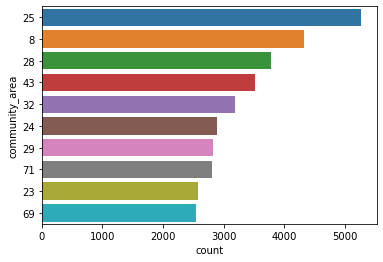

In [133]:
sns.countplot(y= 'community_area', data = crimes, order = crimes['community_area'].value_counts().iloc[:10].index)


The Top 10 highest crime areas broken down as a Bar Plot. From this we can infer that areas 25, 8, and 28 take the lead in reported crimes. We will focus on them for our breakdown of crimes below.

For now let us take a closer look at homicides

<AxesSubplot:ylabel='Count'>

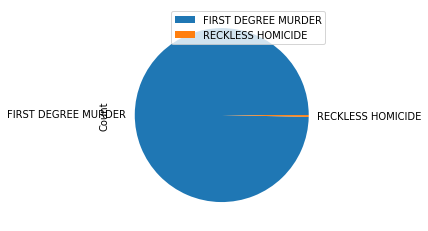

In [134]:
crimes_homicide = crimes[crimes['primary_type'] == 'HOMICIDE']
homivaluect = crimes_homicide.value_counts(crimes['description']).rename_axis('Description').reset_index(name='Count')
homivaluect.groupby(['Description']).sum().plot(kind='pie', y='Count')

One thing we can be sure of is that if someone kills you in Chicago they meant to do it.

In [135]:
homivaluect

Description  Count
0  FIRST DEGREE MURDER    300
1    RECKLESS HOMICIDE      1

While rather high for the average Austrian, our sample on Homicides is overall not that big compared to our dataset. It would probably be useful to look at the actual breakdown of crimes in our Top 3

In [136]:
crimes_25 = crimes[crimes['community_area'] == '25']
crimes_8 = crimes[crimes['community_area'] == '8']
crimes_28 = crimes[crimes['community_area'] == '28']
crimes_68 = crimes[crimes['community_area'] == '68']

First we look at Area 25, Austin

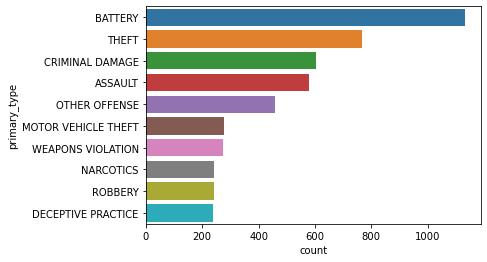

In [137]:
sns.countplot(y = 'primary_type',
              data = crimes_25,
              order = crimes_25['primary_type'].value_counts().iloc[:10].index)
plt.show()

For Area 8, the Near North Side we see an unusually high amount of theft. As the richest part of Chicago it outnumbering violent crime should come to no surprise

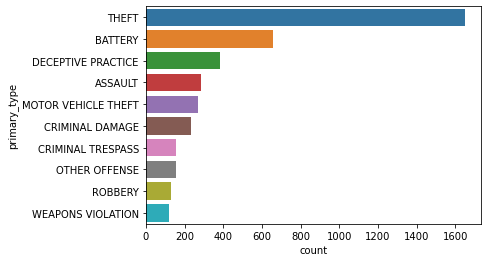

In [138]:
sns.countplot(y = 'primary_type',
              data = crimes_8,
              order = crimes_8['primary_type'].value_counts().iloc[:10].index)
plt.show()

Area 28, The Near West side is another affluent neighborhood and generally regarded as one of the safer areas of Chicago. Theft however seems really outstanding.

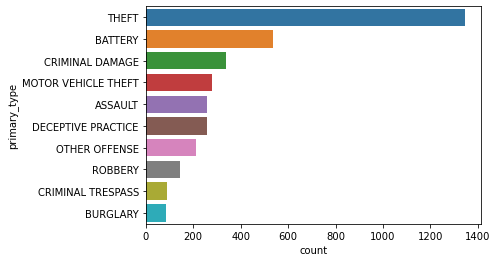

In [139]:
sns.countplot(y = 'primary_type',
              data = crimes_28,
              order = crimes_28['primary_type'].value_counts().iloc[:10].index)
plt.show()

To contrast this we will now look at what is generally considered one of the most dangerous parts of Chicago, Englewood, Number 68. This neighborhood does not even make it to our Top 3

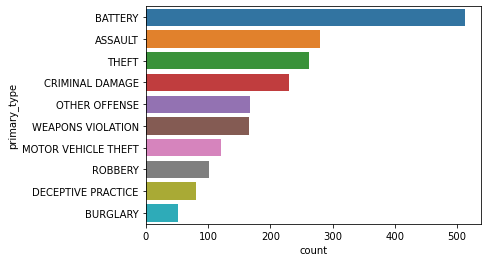

In [140]:
sns.countplot(y = 'primary_type',
              data = crimes_68,
              order = crimes_68['primary_type'].value_counts().iloc[:10].index)
plt.show()

Theft makes for a relaxed third place here as violent crime dominates.

### Numerical analysis of real estate dataset

In [141]:
props["pricesqft"].mean()

371.7488580723851

An average of our square foot pricing. Now let us look at the data for the top 5 cheapest properties.

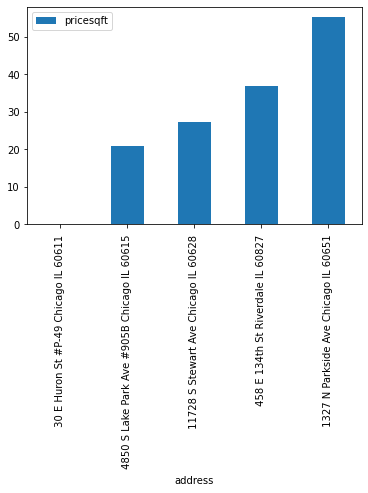

In [142]:
propslargest = props.nsmallest(5,'pricesqft')
propslargest.plot(x ='address', y='pricesqft', kind = 'bar')
plt.show()

Seems like something escaped our dropna(). We will adjust accordingly.

In [143]:
i = props[(props.pricesqft == 0.0)].index
props = props.drop(68)
props

prices                                        address bed_bath_sqft  \
0    230000.0            11302 S Peoria St Chicago IL 60643      4|2|2000    
1    274900.0               3637 W 59th Pl Chicago IL 60629      2|1|1100    
2    219000.0   7641 N Eastlake Ter APT 1D Chicago IL 60626      2|2|1250    
3    108800.0       1132 W Lunt Ave APT 5B Chicago IL 60626      2|1|1054    
4   9400000.0                54 E Scott St Chicago IL 60610      2|1|1054    
..        ...                                            ...           ...   
85   549000.0            5605 N Ottawa Ave Chicago IL 60631      4|4|2904    
86   265000.0   625 W Jackson Blvd APT 310 Chicago IL 60661      2|1|1100    
87   345000.0      5306 N Glenwood Ave #2A Chicago IL 60640       3|1|735    
88   435000.0      300 W Grand Ave APT 602 Chicago IL 60654       1|1|900    
89   534900.0        1522 N Leamington Ave Chicago IL 60651      2|2|1100    

                                          links bed bath   sq_ft    pricesqft  
0            11302 S Peoria St Chicago IL 60643   4    2  2000.0   115.000000  
1               3637 W 59th Pl Chicago IL 60629   2    1  1100.0   249.909091  
2   7641 N Eastlake Ter APT 1D Chicago IL 60626   2    2  1250.0   175.200000  
3       1132 W Lunt Ave APT 5B Chicago IL 60626   2    1  1054.0   103.225806  
4                54 E Scott St Chicago IL 60610   2    1  1054.0  8918.406072  
..                                          ...  ..  ...     ...          ...  
85           5605 N Ottawa Ave Chicago IL 60631   4    4  2904.0   189.049587  
86  625 W Jackson Blvd APT 310 Chicago IL 60661   2    1  1100.0   240.909091  
87     5306 N Glenwood Ave #2A Chicago IL 60640   3    1   735.0   469.387755  
88     300 W Grand Ave APT 602 Chicago IL 60654   1    1   900.0   483.333333  
89       1522 N Leamington Ave Chicago IL 60651   2    2  1100.0   486.272727  

[89 rows x 8 columns]

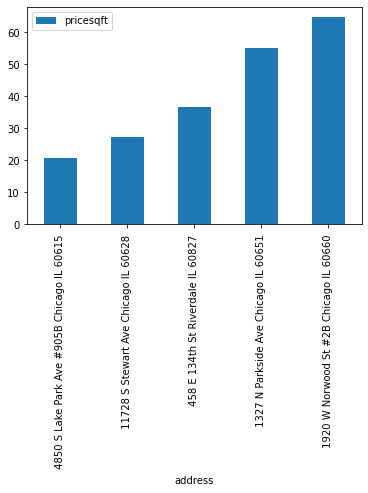

In [144]:
propslargest = props.nsmallest(5,'pricesqft')
propslargest.plot(x ='address', y='pricesqft', kind = 'bar')
plt.show()

Cross referencing with our crime rate count only the 4th property is even in a Top 10 crime affected area, though at the lower spectrum we could always deal with outliers.

### Preparing environment to map crimes to the Chicago city map

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Polygon
from shapely.geometry import Point

%matplotlib inline

In [2]:
street_map = gpd.read_file("chicagoShape/geo_export_66f55090-4ab2-445f-a86f-35bfee177471.shp")

Outputting a sample map of Chicago:

<AxesSubplot:>

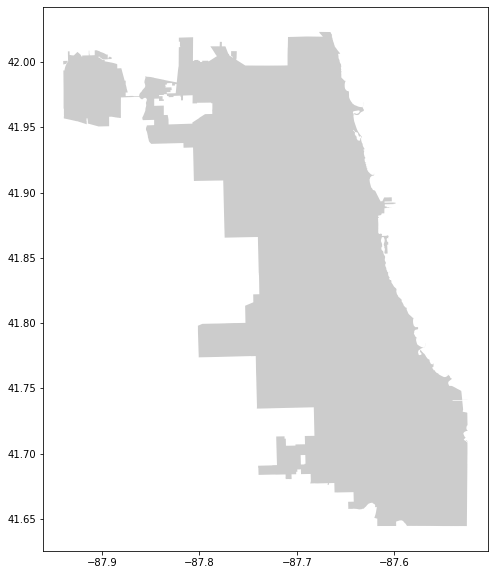

In [4]:
fig, ax = plt.subplots(figsize = (10,10))
street_map.plot(color='grey', ax=ax, alpha = 0.4)

#### Adding location coordinates to the dataframe

Converting columns longitude and latitude to numeric, in order to use thme as coordinates.

In [7]:
crimes[["longitude", "latitude"]] = crimes[["longitude", "latitude"]].apply(pd.to_numeric)
crimes.dtypes

id                                object
case_number                       object
date                      datetime64[ns]
block                             object
iucr                              object
primary_type                      object
description                       object
location_description              object
arrest                            object
domestic                          object
beat                              object
district                          object
ward                              object
community_area                    object
x_coordinate                      object
y_coordinate                      object
updated_on                        object
latitude                         float64
longitude                        float64
location.latitude                 object
location.longitude                object
location.human_address            object
dtype: object

In [8]:
crs = {'init': 'epsg:4326'}

In [9]:
geometry = [Point(xy) for xy in zip(crimes["longitude"], crimes["latitude"])]
geometry[:3]

#### Checking  newly created geometry column that contains gps locations

In [10]:
crime_locs = gpd.GeoDataFrame(crimes, crs=crs, geometry=geometry)
crime_locs.head()

/Users/vasilii/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


id case_number                date                  block  iucr  \
0  12736693    JF287903 2022-06-20 21:56:00  007XX W GARFIELD BLVD  0486   
1  12736637    JF287926 2022-06-20 21:56:00     015XX S KARLOV AVE  143A   
2  12736641    JF287904 2022-06-20 21:54:00      005XX N OGDEN AVE  051A   
3  12736591    JF287899 2022-06-20 21:54:00     034XX S ARCHER AVE  1345   
4  12736636    JF287914 2022-06-20 21:52:00       006XX W 103RD ST  1320   

        primary_type                    description location_description  \
0            BATTERY        DOMESTIC BATTERY SIMPLE            APARTMENT   
1  WEAPONS VIOLATION  UNLAWFUL POSSESSION - HANDGUN               STREET   
2            ASSAULT           AGGRAVATED - HANDGUN               STREET   
3    CRIMINAL DAMAGE    TO CITY OF CHICAGO PROPERTY               STREET   
4    CRIMINAL DAMAGE                     TO VEHICLE               STREET   

  arrest domestic  ... community_area x_coordinate y_coordinate  \
0  false     true  ...             68      1172439      1868272   
1   true    false  ...             29      1149303      1892129   
2   true    false  ...             24      1167891      1903682   
3  false    false  ...             59      1163091      1881589   
4  false    false  ...             73      1173886      1836576   

                updated_on   latitude  longitude location.latitude  \
0  2022-06-27T16:49:20.000  41.793979 -87.643209      41.793979431   
1  2022-06-27T16:49:20.000  41.859925 -87.727431      41.859924664   
2  2022-06-27T16:49:20.000  41.891247 -87.658866      41.891246762   
3  2022-06-27T16:49:20.000  41.830724 -87.677115      41.830723665   
4  2022-06-27T16:49:20.000  41.706970 -87.638841      41.706969624   

   location.longitude                             location.human_address  \
0       -87.643208858  {"address": "", "city": "", "state": "", "zip"...   
1       -87.727431051  {"address": "", "city": "", "state": "", "zip"...   
2       -87.658866407  {"address": "", "city": "", "state": "", "zip"...   
3       -87.677114617  {"address": "", "city": "", "state": "", "zip"...   
4       -87.638840966  {"address": "", "city": "", "state": "", "zip"...   

                     geometry  
0  POINT (-87.64321 41.79398)  
1  POINT (-87.72743 41.85992)  
2  POINT (-87.65887 41.89125)  
3  POINT (-87.67711 41.83072)  
4  POINT (-87.63884 41.70697)  

[5 rows x 23 columns]

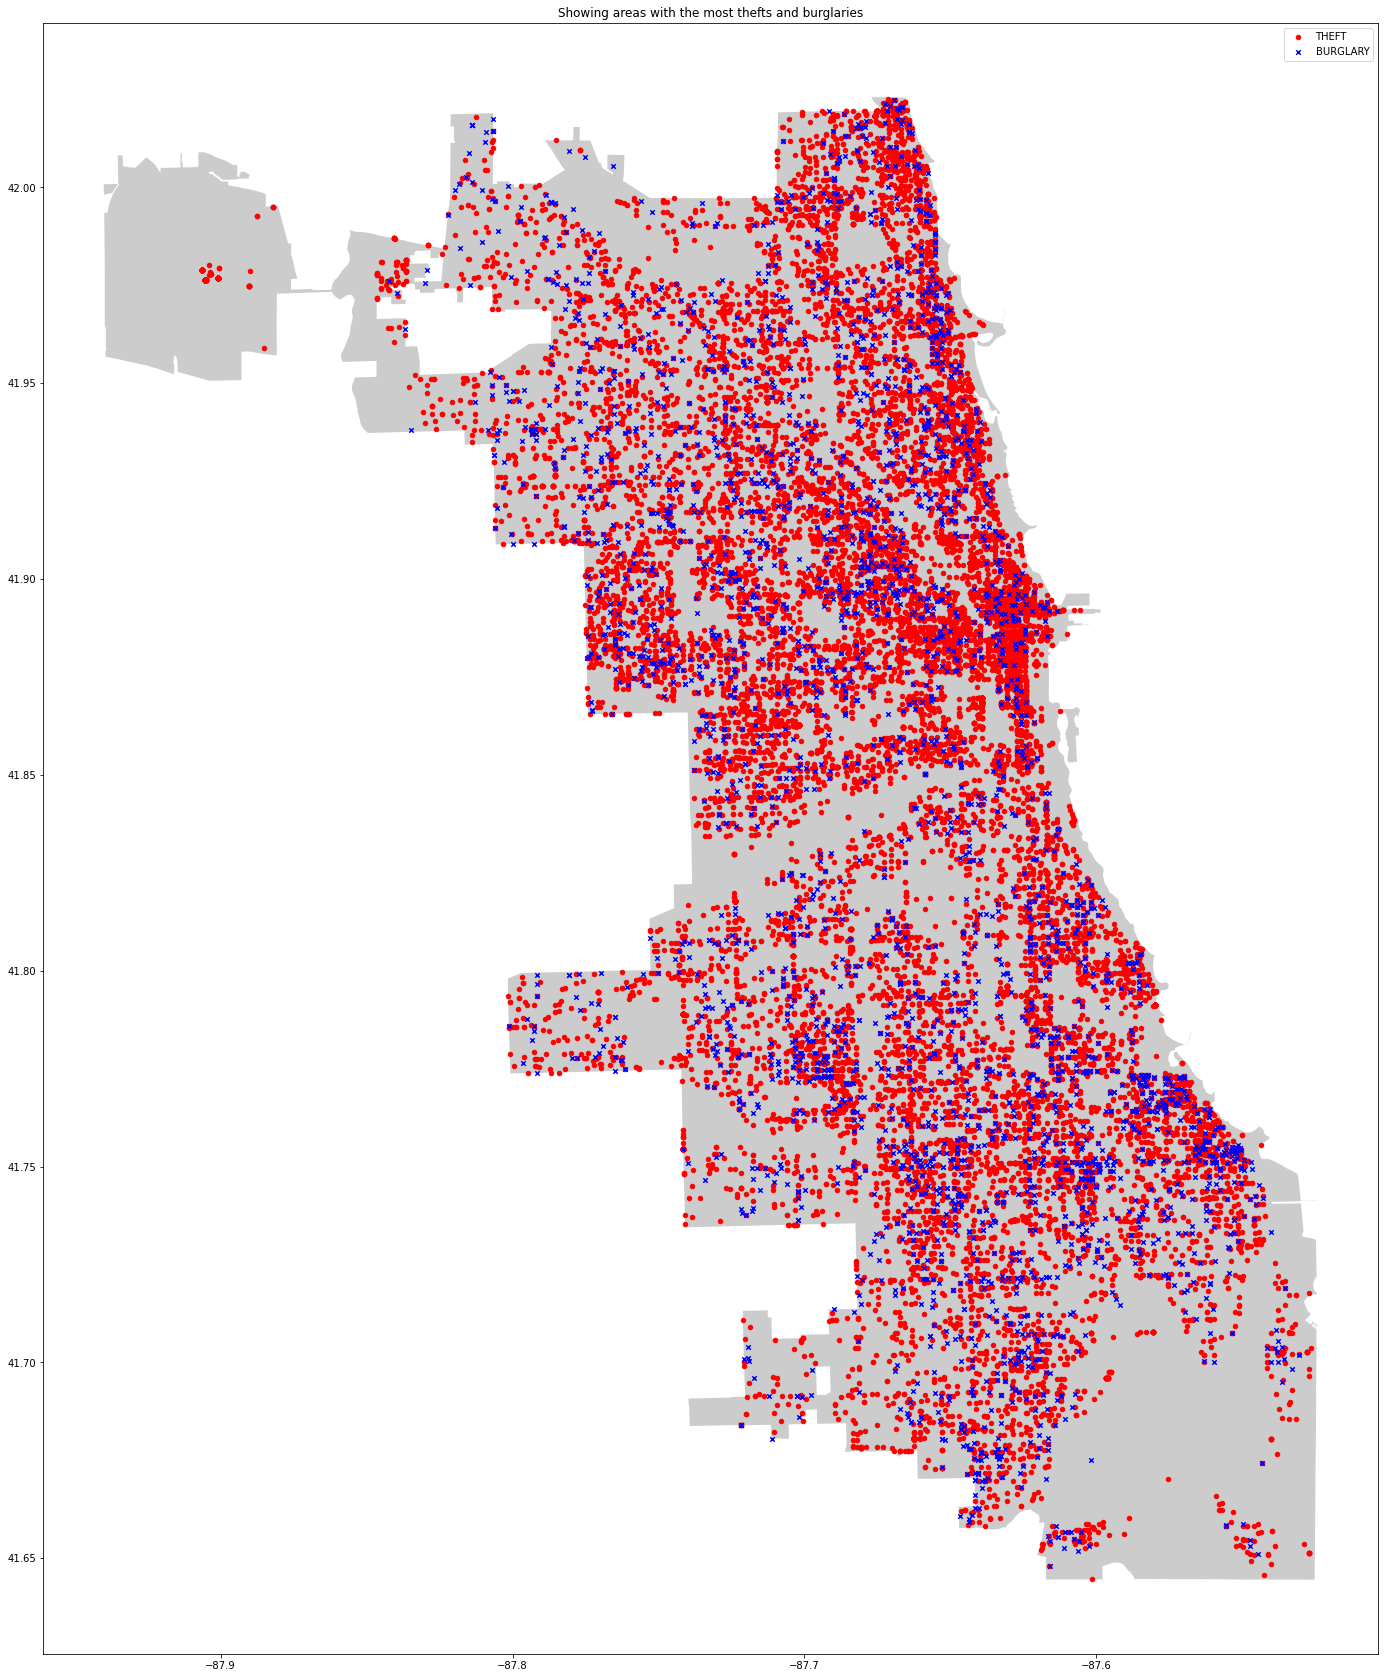

In [21]:
fig, ax = plt.subplots(figsize = (30,30))
street_map.plot(color='grey', ax=ax, alpha = 0.4)
crime_locs[crime_locs['primary_type']=='THEFT'].plot(ax=ax,markersize=20,color='red',marker='o',label="THEFT")
crime_locs[crime_locs['primary_type']=='BURGLARY'].plot(ax=ax,markersize=20,color='blue',marker='x',label="BURGLARY")
plt.title('Showing areas with the most thefts and burglaries')
plt.legend()

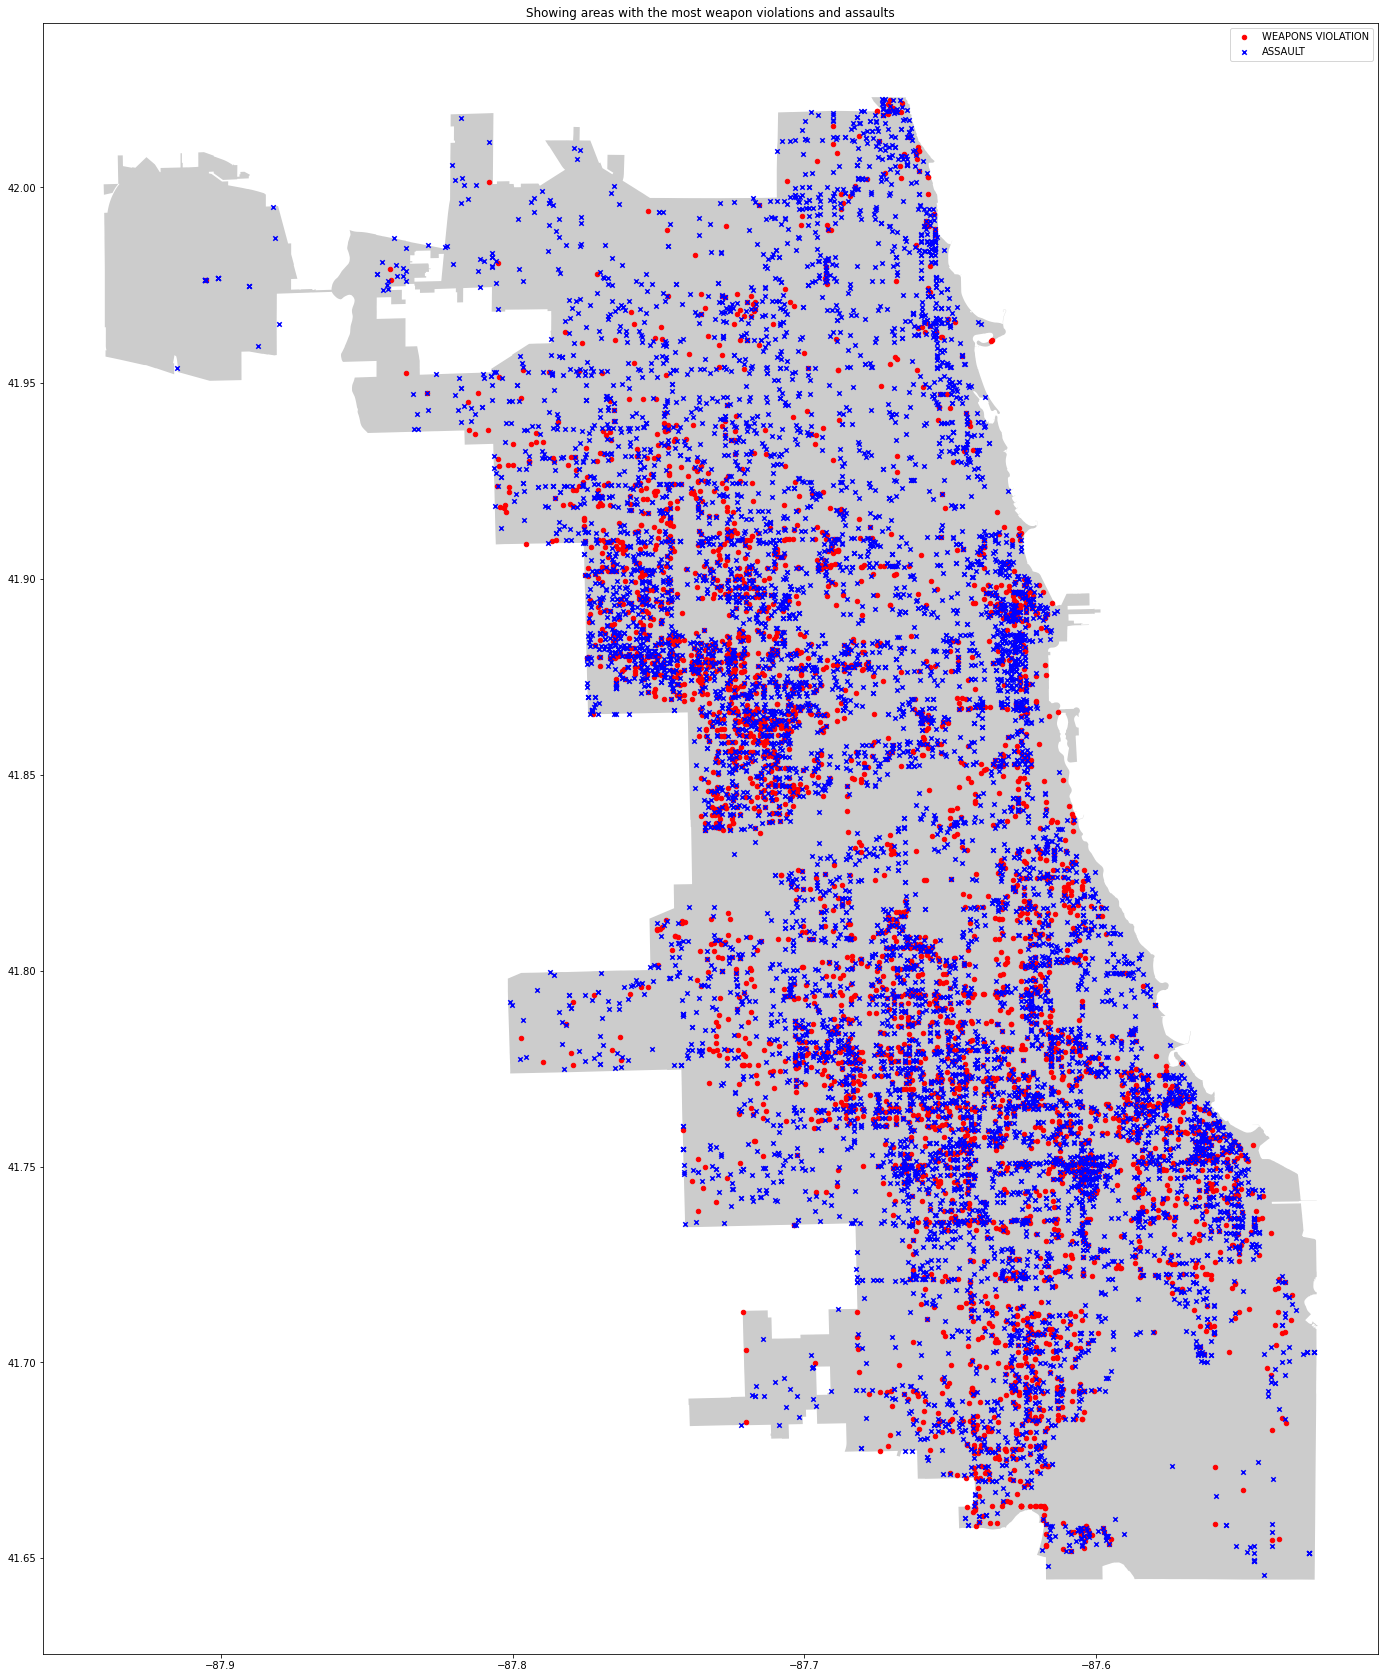

In [20]:
fig, ax = plt.subplots(figsize = (30,30))
street_map.plot(color='grey', ax=ax, alpha = 0.4)
crime_locs[crime_locs['primary_type']=='WEAPONS VIOLATION'].plot(ax=ax,markersize=20,color='red',marker='o',label="WEAPONS VIOLATION")
crime_locs[crime_locs['primary_type']=='ASSAULT'].plot(ax=ax,markersize=20,color='blue',marker='x',label="ASSAULT")
plt.title('Showing areas with the most weapon violations and assaults')
plt.legend()

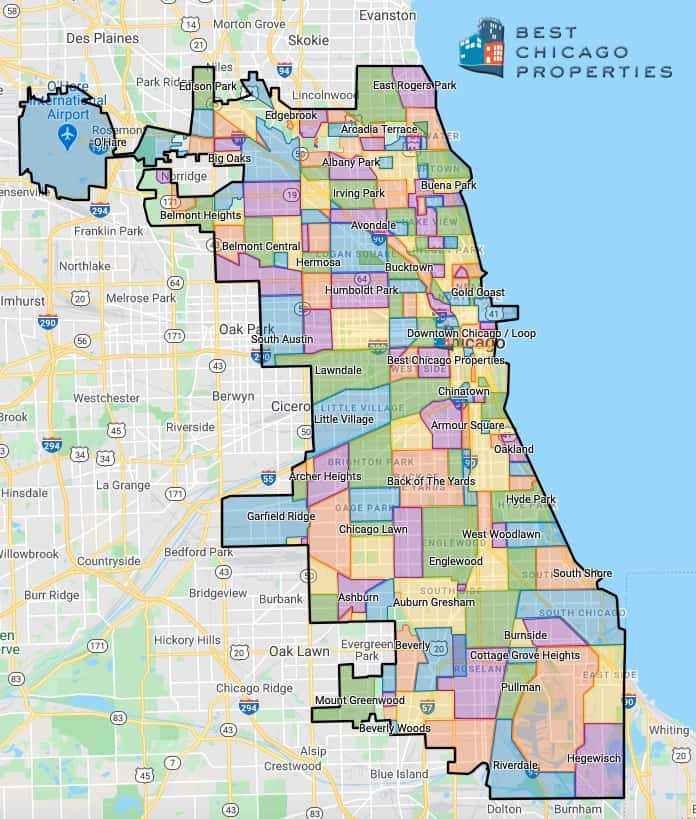

According to our quick analysis, if one wants to live somewhere near the city centre, but would rather settle in a more peaceful neighboorhood, Little Village, Chinatown and Best Chicago are the best options.

In [33]:
expensive = props[props['prices']==props['prices'].max()]
expensive

prices                           address bed_bath_sqft  \
4  9400000.0   54 E Scott St Chicago IL 60610      2|1|1054    

                            links bed bath   sq_ft    pricesqft  
4  54 E Scott St Chicago IL 60610   2    1  1054.0  8918.406072

In [34]:
props = props.drop(props[props.prices == 0].index)
cheap = props[props['prices']==props['prices'].min()]
cheap

prices                                        address bed_bath_sqft  \
46  25000.0   4850 S Lake Park Ave #905B Chicago IL 60615      2|2|1200    

                                          links bed bath   sq_ft  pricesqft  
46  4850 S Lake Park Ave #905B Chicago IL 60615   2    2  1200.0  20.833333

In [51]:
import requests
import urllib.parse

address = '54 E Scott St Chicago IL 60610'
url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

response = requests.get(url).json()
print(response[0]["lat"])
print(response[0]["lon"])

41.90497097691807
-87.62668475422672


#### Most Expensive Property for sale

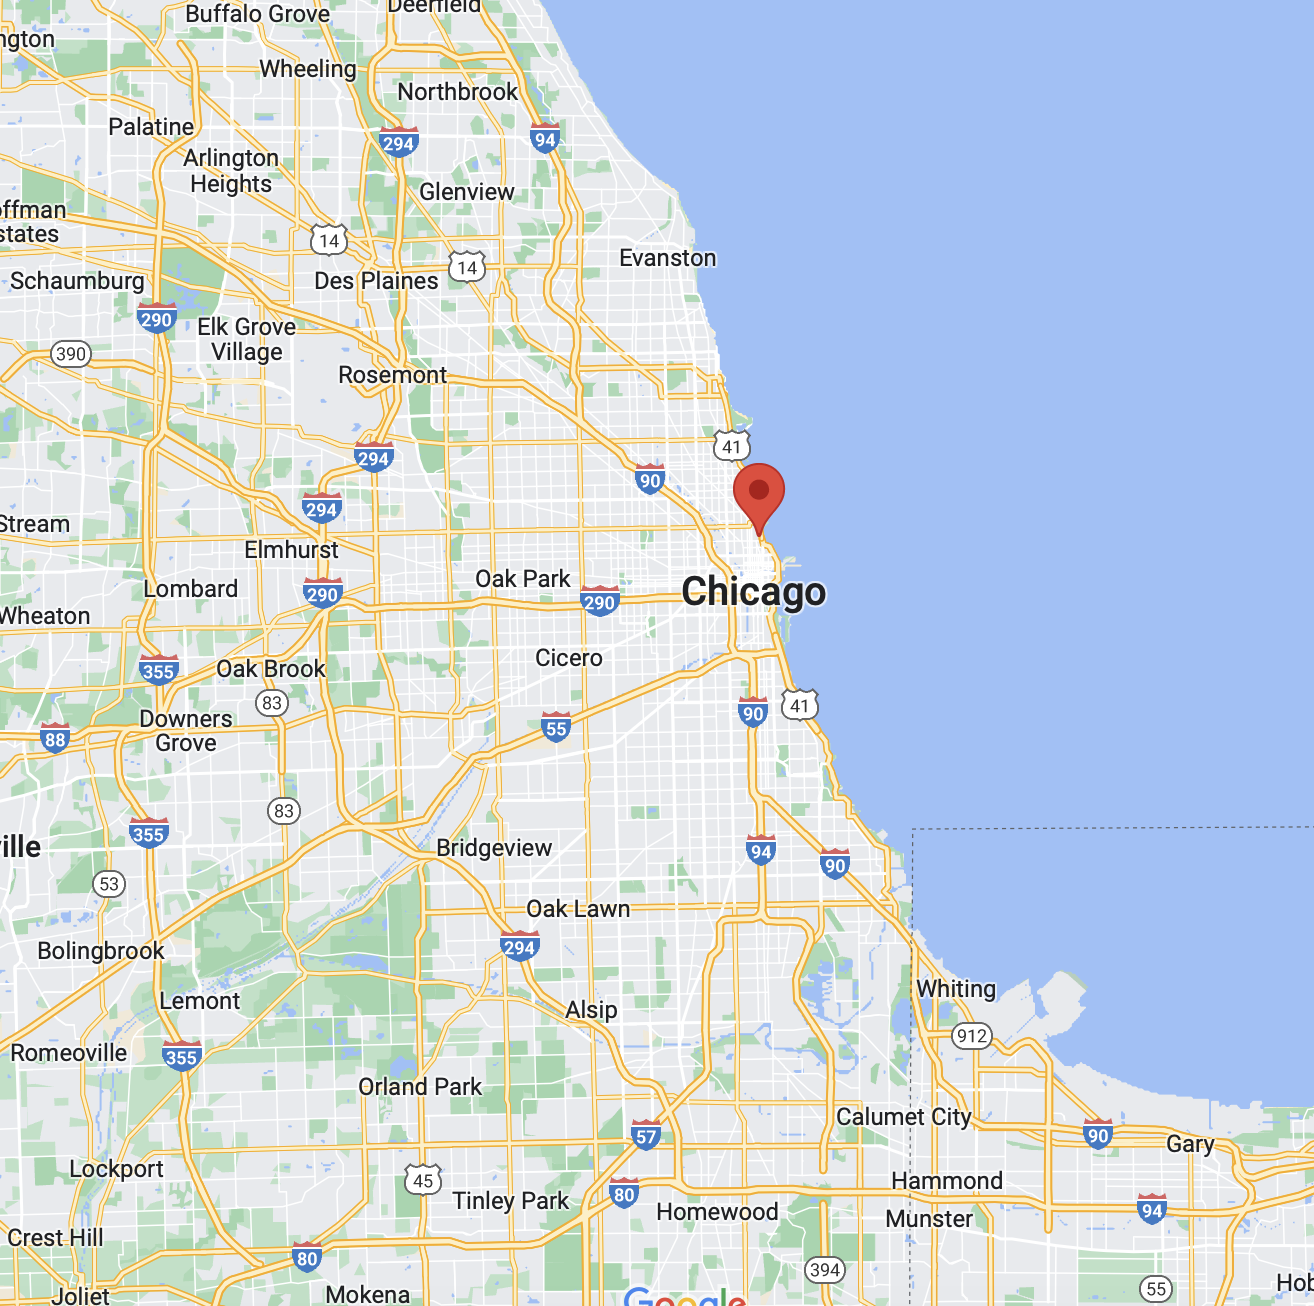

#### Cheapest property for sale

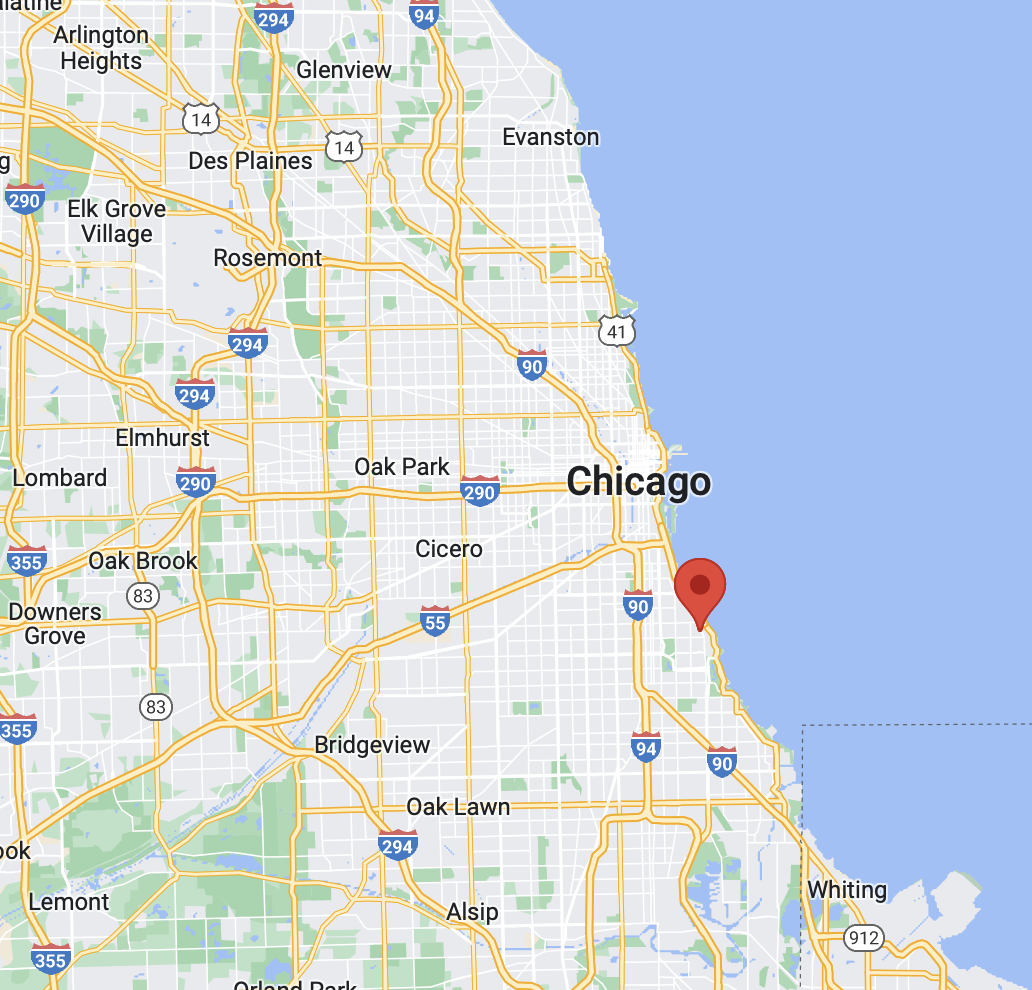